# Deep Learning with TensorFlow
## Formative assessment
### Week 4: Normalising Flows

#### Instructions

In this notebook, you will write code to implement a complete RealNVP normalising flow model, including checkerboard and channel-wise masking, and combining all the components into a multiscale architecture. You will train the normalising flow on the CIFAR-10 dataset.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly.

#### How to submit

Complete all the tasks you are asked for in the notebook. When you have finished and are happy with your code, commit and push your changes to your repository. This will trigger the automated tests, which you will be able to check on GitHub.

Make sure not to change the name or location of this notebook within your repository, or the automated tests will not be able to find it.

#### Let's get started!

We'll start by running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt

# If you would like to make further imports from Tensorflow, add them here






<img src="figures/cifar10.png" alt="CIFAR-10" style="width: 700px;"/> 

#### The CIFAR-10 dataset
In this assignment, you will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

* A. Krizhevsky (2009), "Learning Multiple Layers of Features from Tiny Images", technical report.

Your goal is to develop a RealNVP normalising flow generative model, trained on this dataset. This assignment will roughly follow the architecture described in the original RealNVP paper:

* Dinh, L., Sohl-Dickstein, J. & Bengio, S. (2017), "Density estimation using Real NVP",  in *5th International Conference on Learning Representations, (ICLR)*, Toulon, France, April 24-26, 2017.

An important conceptual point to bear in mind during the course of this assignment, is that we also follow the original paper by thinking of the forward transformation as acting on the input image. Note that this is in contrast to the convention for bijectors of using the forward transformation for sampling, and the inverse transformation for computing log probs.

#### Load and preprocess the dataset

In [3]:
# Load the dataset from tf.keras.datasets

(images_train, labels_train), (images_val, labels_val) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 181s 1us/step


In [4]:
# Define a list for the labels

word_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

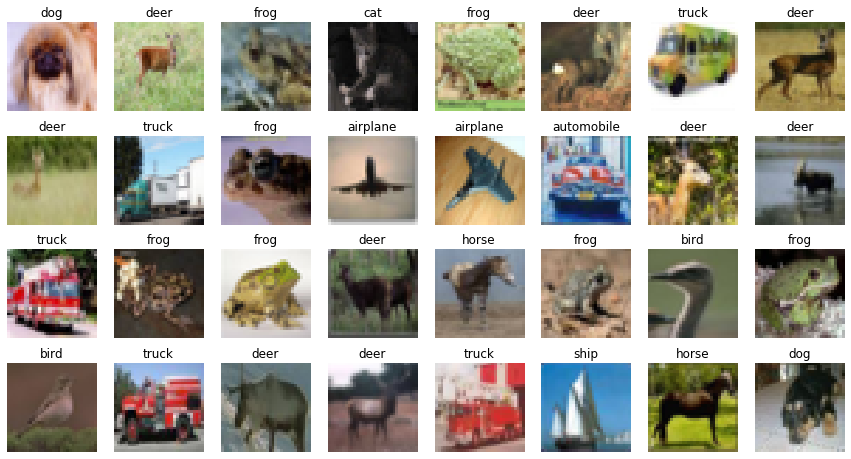

In [166]:
# Display a few images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(images_train.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(images_train[i])
    plt.title(word_labels[int(labels_train[i])])
    plt.axis('off')

You should now write a `get_datasets` function to load the data into `tf.data.Dataset` objects, and preprocess the data ready for training. The function 

* The function takes arguments `images_train`, `images_val`, `shuffle_buffer` and `batch_size`
* Create two Datasets, one for training and one for validation
* Only the images should be loaded into the Datasets; the labels will not be used
* Your function should convert the image dtype to `tf.float32`, rescale so the pixel values lie in the range `[0, 1]`, and repeat the image for both inputs and targets
* The function should then shuffle the training Dataset using the `shuffle_buffer` argument
* It should then batch both Datasets using the `batch_size` argument
* Your function should end with a call to `prefetch` (using the argument `tf.data.experimental.AUTOTUNE`) and return both Datasets in a tuple `(train_ds, valid_ds)`

In [167]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_datasets(images_train, images_val, shuffle_buffer, batch_size):
    """
    This function takes the training and validation images, as well as shuffle_buffer
    and batch_size arguments. It should load and preprocess the data as specified above.
    Your function should then return the Datasets in the tuple (train_ds, valid_ds)
    """
    train_ds = tf.data.Dataset.from_tensor_slices(images_train)
    valid_ds = tf.data.Dataset.from_tensor_slices(images_val)
    
    def map_dataset(img):
        img = tf.cast(img, tf.float32)
        img = img / 255.
        return img, img
    
    train_ds = train_ds.map(map_dataset)
    valid_ds = valid_ds.map(map_dataset)
    
    train_ds = train_ds.shuffle(shuffle_buffer)
    
    train_ds = train_ds.batch(batch_size)
    valid_ds = valid_ds.batch(batch_size)
    
    train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
    valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)
    return train_ds, valid_ds

In [194]:
Conv2D(6, 60, padding='same', kernel_regularizer=tf.keras.regularizers.l2(5e-5))(tf.constant([images_train[0]/255.]))
#tf.constant([images_train[0]/255.])

<tf.Tensor: shape=(1, 32, 32, 6), dtype=float32, numpy=
array([[[[ 0.08496848,  0.03503555,  0.37492558,  0.23917589,
           0.495817  , -0.06002732],
         [ 0.16751213, -0.00635388,  0.36574364,  0.25023663,
           0.4221834 , -0.05019323],
         [ 0.09826961,  0.01145153,  0.28468192,  0.20389651,
           0.34481448, -0.16763046],
         ...,
         [ 0.07844879,  0.20282921,  0.4180607 ,  0.01841022,
          -0.37179053, -0.03437448],
         [ 0.03337498,  0.11008514,  0.39438644, -0.02317101,
          -0.4009367 , -0.09134392],
         [ 0.00645639,  0.04724642,  0.381047  ,  0.01091353,
          -0.31045926, -0.08945659]],

        [[ 0.13238478, -0.05763844,  0.3291423 ,  0.19617435,
           0.42213526, -0.06896282],
         [ 0.20181158, -0.10602946,  0.27386284,  0.1974127 ,
           0.39023453, -0.09753944],
         [ 0.16645981, -0.0513047 ,  0.20903674,  0.19143589,
           0.31431246, -0.19701354],
         ...,
         [ 0.06676938, 

In [7]:
# Run your function to create the Datasets

shuffle_buffer = 500
batch_size = 64
train_ds, valid_ds = get_datasets(images_train, images_val, shuffle_buffer, batch_size)

#### Custom model for log-scale and shift
Recall the equations for the affine coupling layer:

$$
\begin{align}
\left. 
\begin{array}{rcl}
\mathbf{z}_{1:d} &= &\mathbf{x}_{1:d},\\
\mathbf{z}_{d+1:D} &=& \mathbf{x}_{d+1:D}\odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d}).
\end{array}
\right\}\qquad\text{forward pass}
\\[1ex]
\left. 
\begin{array}{rcl}
\mathbf{x}_{1:d} &=& \mathbf{z}_{1:d},\label{realnvp_inv_acl1}\\
\mathbf{x}_{d+1:D} &=& (\mathbf{z}_{d+1:D} - t(\mathbf{z}_{1:d})) \odot \exp(-s(\mathbf{z}_{1:d})).
\end{array}
\right\}\qquad\text{inverse pass}
\end{align}
$$

We will use a custom CNN residual network model for the shift and log-scale parameters that are used in this layer bijector. 

You should now complete the following class to create a custom layer as the residual block for use in this custom model. 

* The class initializer takes `num_filters`, `kernel_size` and `l2reg_coeff` arguments, and optional keyword arguments
  * Any keyword arguments should be passed up to the base class initializer
  * The required arguments should be set as class attributes, to be available to other methods
* The class should implement a `build` method, that creates the model layers
  * There should be two `Conv2D` layers. The first has `num_filters` filters, and the second has the same number of filters as the layer inputs
  * Both `Conv2D` layers should use the `kernel_size` argument to set the kernel size, and should use a ReLU activation and `"SAME"` padding
  * Both `Conv2D` layers should also use $l^2$ kernel regularisation, using the `l2reg_coeff` argument
  * This method should also create two `BatchNormalization` layers
* In the `call` method, the layer inputs should be processed as follows:
  * First, the inputs are passed through the first `Conv2D` layer (with `num_filters` filters)
  * Then they are passed through a `BatchNormalization` layer
  * Then they are processed by the other `Conv2D` layer, and then the other `BatchNormalization` layer
  * Finally, this output should then be added to the original layer input and returned

In [164]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class name or provided methods and signatures.

class Conv2DResidualBlock(tf.keras.layers.Layer):
    
    def __init__(self, num_filters, kernel_size, l2reg_coeff, **kwargs):
        """
        Class initializer takes kernel_size num_filters and l2reg_coeff as arguments, and 
        optional keyword arguments that should be passed to the base Layer class initializer.
        """
        super(Conv2DResidualBlock, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.l2reg_coeff = l2reg_coeff

    def build(self, input_shape):
        input_filters = input_shape[-1]
        self.conv_1 = Conv2D(self.num_filters, kernel_size=self.kernel_size, padding="SAME",
                            activation='relu', kernel_regularizer=l2(self.l2reg_coeff), input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(input_filters, kernel_size=self.kernel_size, padding="SAME",
                            activation='relu', kernel_regularizer=l2(self.l2reg_coeff))
        self.bn_2 = BatchNormalization()

    def call(self, inputs, training=False):
        h = self.conv_1(inputs)
        h = self.bn_1(h)
        h = self.conv_2(h)
        h = self.bn_2(h)
        return h + inputs

In [165]:
# Create residual block layers using your class

resnet_block1 = Conv2DResidualBlock(64, (3, 3), 5e-5, name='resnet1')
resnet_block2 = Conv2DResidualBlock(64, (3, 3), 5e-5, name='resnet2')

In [137]:
# Build and call the first residual block

resnet_block1(tf.random.normal((1, 32, 32, 3))).shape

TensorShape([1, 32, 32, 3])

In [138]:
# Build and call the second residual block

resnet_block2(tf.random.normal((1, 32, 32, 3))).shape

TensorShape([1, 32, 32, 3])

You should now complete the following `get_shift_and_log_scale_resnet` function that builds the full shift and log-scale network, using the `Conv2DResidualBlock` class above.

* This function takes `input_shape`, `kernel_size` and `l2reg_coeff` as arguments, as well as `residual_blocks`, which is a list of `Conv2DResidualBlock` objects
* The function should use the functional API to build the multi-output model
* The model should use the `input_shape` in the function argument to set the shape in the Input layer
* The inputs should be processed sequentially by the layers contained in the `residual_blocks` list
* There should then be a final `Conv2D` layer that processes this output, using the `kernel_size` argument, and $l^2$ kernel regularization using `l2reg_coeff`
  * This `Conv2D` layer should have twice as many filters as the input
  * It should use `"SAME"` padding and have no activation function
* The output of this layer should then be split into two equal-sized Tensors along the final channel axis. These two Tensors are the shift and log-scale Tensors, and should each have the same shape as the model input
* Finally, you should then apply the `tanh` nonlinearity to the log_scale Tensor
* The outputs to the model should be the list of Tensors `[shift, log_scale]`

_Hint: use_ `tf.split` _with arguments_ `num_or_size_splits=2, axis=-1` _to create the output Tensors_.

In [140]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_shift_and_log_scale_resnet(input_shape, kernel_size, l2reg_coeff, residual_blocks):
    
    """
    This function should build the CNN shift and log-scale ResNet model according to the 
    above specification, using the functional API. The model should be multi-output, where
    the output Tensors are [shift, log_scale].
    Your function should return the model.
    """
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs
    input_filters = input_shape[-1]

    for resnet_block in residual_blocks:
        h = resnet_block(h)

    h = Conv2D(2 * input_filters, kernel_size, padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(l2reg_coeff))(h)
    shift, log_scale = tf.split(h, num_or_size_splits=2, axis=-1)
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='conv_resnet')

In [150]:
# Create a shift and log-scale model using your function

shift_and_log_scale = get_shift_and_log_scale_resnet((6, 6, 3), (3, 3), 5e-5, 
                                                     [resnet_block1, resnet_block2])

In [151]:
# Print the model summary

shift_and_log_scale.summary()

Model: "conv_resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 6, 6, 3)]         0         
_________________________________________________________________
resnet1 (Conv2DResidualBlock (None, 6, 6, 3)           3791      
_________________________________________________________________
resnet2 (Conv2DResidualBlock (None, 6, 6, 3)           3791      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 6, 6)           168       
_________________________________________________________________
tf.split_1 (TFOpLambda)      [(None, 6, 6, 3), (None,  0         
_________________________________________________________________
tf.math.tanh_1 (TFOpLambda)  (None, 6, 6, 3)           0         
Total params: 7,750
Trainable params: 7,482
Non-trainable params: 268
___________________________________________________

In [155]:
# Check the output shapes are as expected

print(shift_and_log_scale(tf.random.normal((1, 6, 6, 3)))[0].shape)
print(shift_and_log_scale(tf.random.normal((1, 6, 6, 3)))[1].shape)

(1, 6, 6, 3)
(1, 6, 6, 3)


#### Binary masks

Now that the shift and log-scale model code is complete, you can use it in the implementation of the affine coupling layer. Recall that the affine coupling layer transformations can be rewritten in the following form, using a binary mask $b$:

$$
\begin{align}
\mathbf{z} &= b\odot \mathbf{x} + (1-b)\odot(\mathbf{x}\odot \exp(s(b\odot \mathbf{x})) + t(b\odot\mathbf{x})) & \text{(forward pass)}\\
\mathbf{x} &= b\odot \mathbf{z} + (1-b)\odot((\mathbf{z}-t(b\odot\mathbf{z}))\odot \exp(-s(b\odot \mathbf{z}))) & \text{(inverse pass)}
\end{align}
$$

The following two functions will be used to create the binary masks in this layer.

First, you should complete the following function that builds the channel-wise binary mask. 

* This function takes a single integer `num_channels` as an input
* You can assume that `num_channels` is even
* The function should return a rank-3 Tensor with singleton entries for height and width dimensions
* In the channel axis, the first `num_channels // 2` entries should be zero, and the final `num_channels // 2` entries should be one
* The `dtype` of the returned Tensor should be `tf.float32`
* The function should return the binary mask Tensor

In [156]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def channel_binary_mask(num_channels):
    """
    This function should build and return the channel-wise binary mask as described above,
    with zeros for the first half of the channels, and ones for the remainder.
    Your function should return the binary mask Tensor.
    """
    mask = np.zeros((num_channels,))
    mask[num_channels // 2:] = 1
    return tf.reshape(tf.constant(mask, dtype=tf.float32), [1, 1, num_channels])

In [195]:
# Run your function to see an example channel-wise binary mask

channel_binary_mask(2)

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0., 1.]]], dtype=float32)>

The following function creates the checkerboard binary mask.

* The function takes `shape` as an input, which is a integer tuple of length 2, corresponding to the height and width dimensions
* You can assume both height and width dimensions are even integers
* The function should return a rank-3 Tensor with a singleton entry in the channel dimension
* In the spatial dimensions, the entry at index `[0, 0]` should be zero. The remaining entries should be filled with ones and zeros in a checkerboard pattern
* The `dtype` of the returned Tensor should be `tf.float32`
* The function should return the binary mask Tensor

In [159]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def checkerboard_binary_mask(shape):
    """
    This function should build and return the spatial checkerboard binary mask as 
    described above, with a zero in the [0, 0] entry in the spatial dimensions.
    Your function should return the binary mask Tensor.
    """
    height, width = shape[0], shape[1]
    height_range = tf.range(height)
    width_range = tf.range(width)
    height_odd_inx = tf.cast(tf.math.mod(height_range, 2), dtype=tf.bool)
    width_odd_inx = tf.cast(tf.math.mod(width_range, 2), dtype=tf.bool)
    odd_rows = tf.tile(tf.expand_dims(height_odd_inx, -1), [1, width])
    odd_cols = tf.tile(tf.expand_dims(width_odd_inx, 0), [height, 1])
    checkerboard_mask = tf.math.logical_xor(odd_rows, odd_cols)
    return tf.cast(tf.expand_dims(checkerboard_mask, -1), tf.float32)

In [160]:
# Run your function to see an example checkerboard binary mask

tf.squeeze(checkerboard_binary_mask((6, 6)))

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0.]], dtype=float32)>

#### Affine coupling layer

The following is the same class that we implemented in this week's coding tutorial. It will work with either of the binary masks above.

In [161]:
# Create the AffineCouplingLayer class

class AffineCouplingLayer(tfb.Bijector):

    def __init__(self, shift_and_log_scale_fn, mask, **kwargs):
        super(AffineCouplingLayer, self).__init__(
            forward_min_event_ndims=1, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def _forward(self, x):
        t, log_s = self.shift_and_log_scale_fn(x * self.b)
        y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
        return y

    def _inverse(self, y):
        t, log_s = self.shift_and_log_scale_fn(y * self.b)
        x = self.b * y + (1 - self.b) * ((y - t) * tf.exp(-log_s))
        return x

    def _forward_log_det_jacobian(self, x):
        _, log_s = self.shift_and_log_scale_fn(x * self.b)
        return tf.reduce_sum(log_s * (1 - self.b), axis=-1)  

    def _inverse_log_det_jacobian(self, y):
        _, log_s = self.shift_and_log_scale_fn(y * self.b)
        return -tf.reduce_sum(log_s * (1 - self.b), axis=-1)

In [162]:
# Create an affine coupling layer with a checkerboard mask

mask = checkerboard_binary_mask((6, 6))
affine_coupling_layer = AffineCouplingLayer(shift_and_log_scale, mask)

In [163]:
# View an example layer output - look at only one channel dimension for easier viewing

output = affine_coupling_layer.forward(tf.ones((1, 6, 6, 3)))
print(tf.squeeze(output)[...,0])

tf.Tensor(
[[0.9285437 1.        0.8813149 1.        0.8908565 1.       ]
 [1.        1.0790234 1.        1.0955106 1.        1.1864169]
 [1.2164522 1.        1.1158038 1.        1.154209  1.       ]
 [1.        1.0693097 1.        1.1191404 1.        1.2120123]
 [1.2207847 1.        1.1497813 1.        1.1822324 1.       ]
 [1.        0.8849122 1.        0.9129913 1.        1.0258816]], shape=(6, 6), dtype=float32)


In the above example, you should find that the masked elements are unchanged.

#### Combining the affine coupling layers

Recall that the affine coupling layers are combined into groups of 3 or 4 in the RealNVP architecture. Within each group, successive affine coupling layers are applied with alternating masks.

You should now complete the following function to build one of these blocks. 

* The function takes `shift_and_log_scale_fns` and `mask` as an argument
* The `shift_and_log_scale_fns` is a list or tuple of shift and log scale objects (as used in the `AffineCouplingLayer` above
* The `mask` argument is either a channel-wise or checkerboard mask Tensor
* The function should create a new bijector, that consists of successive `AffineCouplingLayer` objects chained together
  * The first affine coupling layer should use the mask passed in the `mask` argument
  * Following affine coupling layers should use alternating masks (of the same type)
* The function should return the bijector object

In [ ]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def affine_coupling_layer_block(shift_and_log_scale_fns, mask):
    """
    This function should build the block of affine coupling layers as described above.
    It should use the shift and log scale models passed in the list in successive
    affine coupling layers, with alternating masks from one to the next.
    Your function should return a bijector object representing the block.
    """
    affine_coupling_layers = []
    for shift_and_log_scale in shift_and_log_scale_fns:
        affine_coupling_layers.append(AffineCouplingLayer(shift_and_log_scale, mask))
        mask = 1 - mask
    return tfb.Chain(list(reversed(affine_coupling_layers)))

In [ ]:
# Create an affine coupling layer block

resnet_block1 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block2 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_1 = get_shift_and_log_scale_resnet((32, 32, 3), (3, 3), 5e-5, 
                                                     [resnet_block1, resnet_block2])

resnet_block3 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block4 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_2 = get_shift_and_log_scale_resnet((32, 32, 3), (3, 3), 5e-5, 
                                                     [resnet_block3, resnet_block4])

resnet_block5 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block6 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_3 = get_shift_and_log_scale_resnet((32, 32, 3), (3, 3), 5e-5, 
                                                     [resnet_block5, resnet_block6])

mask = checkerboard_binary_mask((32, 32))

acl_block_1 = affine_coupling_layer_block([shift_and_log_scale_1, 
                                           shift_and_log_scale_2, 
                                           shift_and_log_scale_3],
                                          mask)

#### The squeeze operation

In the RealNVP architecture, after an affine coupline layer block with checkerboard masking (as above), there is a squeeze operation, where the spatial dimensions of the layer are divided into $2\times 2\times c$ subsquares, and reshaped into $1\times 1\times 4c$.

The squeezing operation is also a bijective operation. The `_forward`, `_inverse`, `_forward_log_det_jacobian` and `_inverse_log_det_jacobian` methods have been completed for you in the `Squeeze` class below. 

However, this bijector also changes the shape of its input, and so requires the `_forward_event_shape_tensor` and `_inverse_event_shape_tensor` methods to be implemented. You should now complete the `Squeeze` class implementation by writing these methods.

* The `_forward_event_shape_tensor` method takes an `input_shape` argument, and the `_inverse_event_shape_tensor` method takes an `output_shape` argument
* The arguments for both methods are a `tf.int32` rank-1 Tensor representing the shape of an input
* The `_forward_event_shape_tensor` and `_inverse_event_shape_tensor` methods should return the transformed shape under the `forward` and `inverse` methods respectively
* The returned shape should also be a `tf.int32` rank-1 Tensor
* The length of `input_shape` and `output_shape` will be at least 3 (since `forward_min_event_ndims=3`), but these methods should account for the possibility that the rank of the inputs/outputs could be greater than 3

In [ ]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class name or provided methods and signatures.

class Squeeze(tfb.Bijector):
    
    def __init__(self, name='Squeeze', **kwargs):
        super(Squeeze, self).__init__(forward_min_event_ndims=3, is_constant_jacobian=True, 
                                      name=name, **kwargs)

    def _forward(self, x):
        input_shape = x.shape
        height, width, channels = input_shape[-3:]
        y = tfb.Reshape((height // 2, 2, width // 2, 2, channels), event_shape_in=(height, width, channels))(x)
        y = tfb.Transpose(perm=[0, 2, 1, 3, 4])(y)
        y = tfb.Reshape((height // 2, width // 2, 4 * channels),
                        event_shape_in=(height // 2, width // 2, 2, 2, channels))(y)
        return y

    def _inverse(self, y):
        input_shape = y.shape
        height, width, channels = input_shape[-3:]
        x = tfb.Reshape((height, width, 2, 2, channels // 4), event_shape_in=(height, width, channels))(y)
        x = tfb.Transpose(perm=[0, 2, 1, 3, 4])(x)
        x = tfb.Reshape((2 * height, 2 * width, channels // 4),
                        event_shape_in=(height, 2, width, 2, channels // 4))(x)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0., y.dtype)

    def _forward_event_shape_tensor(self, input_shape):
        """
        This method takes a rank-1 tf.int32 input_shape Tensor as input.
        It should compute the transformed shape under the forward method.
        The transformed shape should be returned as a rank-1 tf.int32 Tensor.
        """
        extra_event_dims = input_shape[:-3]
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        transformed_hwc = tf.stack((height // 2, width // 2, 4 * channels))
        return tf.concat((extra_event_dims, transformed_hwc), axis=0)

    def _inverse_event_shape_tensor(self, output_shape):
        """
        This method takes a rank-1 tf.int32 input_shape Tensor as input.
        It should compute the transformed shape under the inverse method.
        The transformed shape should be returned as a rank-1 tf.int32 Tensor.
        """
        extra_event_dims = output_shape[:-3]
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        transformed_hwc = tf.stack((2 * height, 2 * width, channels // 4))
        return tf.concat((extra_event_dims, transformed_hwc), axis=0)

In [ ]:
# Test the Squeeze bijector

squeeze = Squeeze()
squeeze(tf.ones((10, 32, 32, 3))).shape

In [ ]:
# Test the inverse operation

squeeze.inverse(tf.ones((10, 4, 4, 96))).shape

#### Multiscale architecture

You are now ready to bring all of the components together in the complete multiscale architecture. The RealNVP model that we will build will factor out latent variables to downscale the input only once. This model is visualised in the following diagram:

<img src="figures/realnvp_model.png" alt="RealNVP model" style="width: 800px;"/>

We have already instantiated the first of these affine couple layer blocks above. The following two cells instantiate the remaining two blocks.

In [ ]:
# Create the second affine coupling layer block

resnet_block7 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block8 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_4 = get_shift_and_log_scale_resnet((16, 16, 12), (3, 3), 5e-5, 
                                                     [resnet_block7, resnet_block8])

resnet_block9 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block10 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_5 = get_shift_and_log_scale_resnet((16, 16, 12), (3, 3), 5e-5, 
                                                     [resnet_block9, resnet_block10])

resnet_block11 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block12 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_6 = get_shift_and_log_scale_resnet((16, 16, 12), (3, 3), 5e-5, 
                                                     [resnet_block11, resnet_block12])

mask = channel_binary_mask(12)

acl_block_2 = affine_coupling_layer_block([shift_and_log_scale_4, 
                                           shift_and_log_scale_5, 
                                           shift_and_log_scale_6],
                                          mask)

In [ ]:
# Create the third affine coupling layer block

resnet_block13 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block14 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_7 = get_shift_and_log_scale_resnet((16, 16, 6), (3, 3), 5e-5, 
                                                     [resnet_block13, resnet_block14])

resnet_block15 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block16 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_8 = get_shift_and_log_scale_resnet((16, 16, 6), (3, 3), 5e-5, 
                                                     [resnet_block15, resnet_block16])

resnet_block17 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block18 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_9 = get_shift_and_log_scale_resnet((16, 16, 6), (3, 3), 5e-5, 
                                                     [resnet_block17, resnet_block18])

resnet_block19 = Conv2DResidualBlock(64, (3, 3), 5e-5)
resnet_block20 = Conv2DResidualBlock(64, (3, 3), 5e-5)
shift_and_log_scale_10 = get_shift_and_log_scale_resnet((16, 16, 6), (3, 3), 5e-5, 
                                                        [resnet_block19, resnet_block20])

mask = checkerboard_binary_mask((16, 16))

acl_block_3 = affine_coupling_layer_block([shift_and_log_scale_7, 
                                           shift_and_log_scale_8, 
                                           shift_and_log_scale_9,
                                           shift_and_log_scale_10],
                                          mask)

You should now implement the multiscale architecture in the following subclassed bijector. This bijector should be constructed to be able to operate on a batch of Tensors of shape `(H, W, C)`, with the only assumption being that `H` and `W` are both even.

* The initializer takes the three affine coupling layer blocks that are part of the above architecture:
  * `acl_block_1` is a block with 3 affine coupling layers with checkerboard masking
  * `acl_block_2` is a block with 3 affine coupling layers with channel masking
  * `acl_block_3` is n block with 4 affine coupling layers with checkerboard masking
* You should implement the `_forward`, `_inverse`, `_forward_log_det_jacobian`, `_inverse_log_det_jacobian`, `_forward_event_shape_tensor` and `_inverse_event_shape_tensor` methods
* The forward transformation should operate on the inputs as depicted above:
  * It should pass the inputs through the first ACL block, a `Squeeze` operation, and then the second ACL block
  * It should then split the Tensor in half along the channel axis
  * The first half of the channel dimesions should be used as latent variables. Call this $\mathbf{z}^{(1)}$
  * The second half of the channel dimensions (call this $\mathbf{h}^{(1)}$) should be further processed through the third ACL block to produce $\mathbf{z}^{(2)}$
  * The final latent variable $\mathbf{z} = (\mathbf{z}^{(1)}, \mathbf{z}^{(2)})$ should concatenate along the channel dimension. This should be returned by the `_forward` method
* The `_inverse` method should perform precisely the inverse of the `_forward` method
* The `_forward_log_det_jacobian` method should compute the log determinant of the Jacobian of the forward transformation, using the `forward_log_det_jacobian` method of each ACL block bijector
* The `_inverse_log_det_jacobian` method should compute the log determinant of the Jacobian of the inverse transformation, using the `inverse_log_det_jacobian` method of each ACL block bijector
* Since this bijector changes the shape of the input, it is necessary to complete `_forward_event_shape_tensor` and `_inverse_event_shape_tensor` methods
  * Note that these methods will be the same as for the `Squeeze` bijector above
  
_Hint: use_ `tf.split` _and_ `tf.concat` _to factor out (and recombine) latent variables in the forward and inverse passes._

In [ ]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class name or provided methods and signatures.

class RealNVPMultiScale(tfb.Bijector):
    
    def __init__(self, acl_block_1, acl_block_2, acl_block_3, **kwargs):
        super(RealNVPMultiScale, self).__init__(forward_min_event_ndims=3, **kwargs)
        self.acl_block_1 = acl_block_1
        self.acl_block_2 = acl_block_2
        self.acl_block_3 = acl_block_3
        self.squeeze = Squeeze()

    def _forward(self, x):
        """
        This function computes the forward transformation as described above.
        It takes an input image batch x, and returns a latent variable batch z.
        """
        h = self.acl_block_1.forward(x)
        h = self.squeeze.forward(h)
        h = self.acl_block_2.forward(h)
        z1, h1 = tf.split(h, 2, axis=-1)
        z2 = self.acl_block_3.forward(h1)
        return tf.concat([z1, z2], axis=-1)
        
    def _inverse(self, z):
        """
        This function computes the inverse transformation as described above.
        It takes a latent variable batch z, and returns an input image batch x.
        """
        z1, z2 = tf.split(z, 2, axis=-1)
        h1 = self.acl_block_3.inverse(z2)
        h = tf.concat([z1, h1], axis=-1)
        h = self.acl_block_2.inverse(h)
        h = self.squeeze.inverse(h)
        return self.acl_block_1.inverse(h)

    def _forward_log_det_jacobian(self, x):
        """
        This function computes the log determinant of the Jacobian of the
        forward transformation as described above.
        It takes an input image batch x, and returns a Tensor with the event dimensions reduced out.
        """
        log_det1_1 = self.acl_block_1.forward_log_det_jacobian(x, event_ndims=3)
        h = self.acl_block_1.forward(x)
        h = self.squeeze.forward(h)
        log_det1_2 = self.acl_block_2.forward_log_det_jacobian(h, event_ndims=3)
        h = self.acl_block_2.forward(h)
        _, h1 = tf.split(h, 2, axis=-1)
        log_det2 = self.acl_block_3.forward_log_det_jacobian(h1, event_ndims=3)
        return log_det1_1 + log_det1_2 + log_det2

    def _inverse_log_det_jacobian(self, z):
        """
        This function computes the log determinant of the Jacobian of the
        inverse transformation as described above.
        It takes a latent variable batch z, and returns a Tensor with the event dimensions reduced out.
        """
        z1, z2 = tf.split(z, 2, axis=-1)
        log_det2 = self.acl_block_3.inverse_log_det_jacobian(z2, event_ndims=3)
        h1 = self.acl_block_3.inverse(z2)
        h = tf.concat([z1, h1], axis=-1)
        log_det1_2 = self.acl_block_2.inverse_log_det_jacobian(h, event_ndims=3)
        h = self.acl_block_2.inverse(h)
        h = self.squeeze.inverse(h)
        log_det1_1 = self.acl_block_1.inverse_log_det_jacobian(h, event_ndims=3)
        return log_det1_1 + log_det1_2 + log_det2

    def _forward_event_shape_tensor(self, input_shape):
        """
        This method should be the same as for the Squeeze bijector.
        """
        extra_event_dims = input_shape[:-3]
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        transformed_hwc = tf.stack((height // 2, width // 2, 4 * channels))
        return tf.concat((extra_event_dims, transformed_hwc), axis=0)

    def _inverse_event_shape_tensor(self, output_shape):
        """
        This method should be the same as for the Squeeze bijector.
        """
        extra_event_dims = output_shape[:-3]
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        transformed_hwc = tf.stack((2 * height, 2 * width, channels // 4))
        return tf.concat((extra_event_dims, transformed_hwc), axis=0)

In [ ]:
# Build the RealNVP model

realnvp = RealNVPMultiScale(acl_block_1, acl_block_2, acl_block_3)

#### Data preprocessing bijector

We will also preprocess the image data before sending it through the RealNVP model. To do this, for a Tensor $\mathbf{x}$ of pixel values in $[0, 1]^D$, we transform $\mathbf{x}$ according to the following (all operations performed elementwise):

$$
T(\mathbf{x}) = \text{logit}\left(\alpha + (1 - 2\alpha)\mathbf{x}\right),
$$

where $\alpha$ is a parameter, and the logit function is the inverse of the sigmoid function, which is given by 

$$
\text{logit}(p) = \log (p) - \log (1 - p).
$$

You should now complete the following function to construct this bijector from in-built bijectors from the bijectors module.

* The function takes the parameter `alpha` as an input, which you can assume to take a small positive value ($\ll0.5$)
* The function should construct and return a bijector that computes $T(\mathbf{x})$ in the forward pass

In [ ]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_preprocess_bijector(alpha):
    """
    This function should create a chained bijector that computes the 
    transformation T in equation (7) above.
    This can be computed using in-built bijectors from the bijectors module.
    Your function should then return the chained bijector.
    """
    scale = tfb.Scale(1 - 2*alpha)
    shift = tfb.Shift(alpha)
    logit = tfb.Invert(tfb.Sigmoid())
    return tfb.Chain([logit, shift, scale])

In [ ]:
# Create an instance of the preprocess bijector

preprocess = get_preprocess_bijector(0.05)

#### Train the RealNVP model

We will use the following model class to help with the training process.

In [ ]:
# Helper custom model for training

class RealNVPModel(Model):

    def __init__(self, realnvp_multiscale, preprocess, **kwargs):
        super(RealNVPModel, self).__init__(**kwargs)
        self.preprocess = preprocess
        self.realnvp_multiscale = realnvp_multiscale
        self.bijector = tfb.Chain([self.realnvp_multiscale, self.preprocess])
        
    def build(self, input_shape):
        output_shape = self.bijector(tf.expand_dims(tf.zeros(input_shape[1:]), axis=0)).shape
        self.base = tfd.Independent(tfd.Normal(loc=tf.zeros(output_shape[1:]), scale=1.),
                                    reinterpreted_batch_ndims=3)
        self._bijector_variables = (
            list(self.bijector.variables))
        self.flow = tfd.TransformedDistribution(
            distribution=self.base,
            bijector=tfb.Invert(self.bijector),
        )
        super(RealNVPModel, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        return self.flow

    def sample(self, batch_size):
        sample = self.base.sample(batch_size)
        return self.bijector.inverse(sample)

In [ ]:
# Create an instance of the RealNVPModel class

realnvp_model = RealNVPModel(realnvp, preprocess)
realnvp_model.build((1, 32, 32, 3))

Note that the model's `call` method returns the `TransformedDistribution` object. Also, we have set up our datasets to return the input image twice as a 2-tuple. This is so we can train our model with negative log-likelihood as normal.

In [ ]:
# Define the negative log-likelihood loss function

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
# Compile and train the model

optimizer = tf.keras.optimizers.Adam()
realnvp_model.compile(loss=nll, optimizer=optimizer)
realnvp_model.fit(train_ds, validation_data=valid_ds, epochs=20)

#### Generate some samples

In [ ]:
# Sample from the model

n_images = 12
samples = realnvp_model.sample(n_images).numpy()

In [ ]:
# Display the samples

f, axs = plt.subplots(2, n_images // 2, figsize=(17, 6))
for k, image in enumerate(samples):
    i = k % 2
    j = k // 2
    axs[i, j].imshow(np.clip(image, 0., 1.))
    axs[i, j].axis('off')
f.subplots_adjust(wspace=0.03, hspace=0.03)

In this assignment you have developed a full implementation of the RealNVP architecture, including the affine coupling layers with channel-wise and checkerboard masking, CNN ResNet networks for the shift and log scale functions, the squeeze operation and multiscale architecture. For optimal performance, the model should be larger and trained for longer. The architecture in the original paper also contains some additional features.

In the next week of the module, we will expand on our skills with the TensorFlow Probability library and use it to develop another probabilistic deep learning algorithm; the variational autoencoder.